In [2]:
import pandas as pd

matches = pd.read_csv('./data/matches.csv')
players = pd.read_csv('./data/match_players.csv')


In [3]:
# look at matches
display(matches.info())
matches.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331699 entries, 0 to 1331698
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   token           1331699 non-null  object 
 1   winning_team    1331699 non-null  int64  
 2   mirror          1331699 non-null  bool   
 3   ladder          1331699 non-null  object 
 4   patch           1331699 non-null  int64  
 5   average_rating  1287122 non-null  float64
 6   map             1331699 non-null  object 
 7   map_size        1331699 non-null  object 
 8   num_players     1331699 non-null  int64  
 9   server          1331699 non-null  object 
 10  duration        1331699 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 102.9+ MB


None

,token,winning_team,mirror,ladder,patch,average_rating,map,map_size,num_players,server,duration
0,HEVMmsI8GDCKKR2W,2,False,RM_1v1,35584,1180.0,hideout,tiny,2,ukwest,0:06:30
1,8a93d8306c758c0e,2,False,RM_1v1,36906,1671.0,nomad,tiny,2,westus2,0:03:39
2,1M1GiBrNTyfDdYpp,1,False,RM_TEAM,35584,1144.0,golden_pit,medium,4,brazilsouth,0:51:20
3,WqaPjpZ5YJsoF48B,1,False,RM_1v1,35584,943.0,golden_pit,tiny,2,eastus,0:37:14
4,sOZrU57m89qr0159,1,False,RM_1v1,35584,1046.0,mediterranean,tiny,2,ukwest,0:36:49


# What can we ask about matches?
- most popular maps
-- likely arabia (open) and arena (closed)
- most popular game type (ladder)
- what civs win most?
-- civ win rate vs other civs
-- civ win rate in map (arabia vs arena)
- what type of civ is better (infantry, cavalry, archer)
-- need to label civs by type manually
- in mirror matches, does the higher rated player win more often ? (probably). but we don't seem to have player rating here, just average rating
- where do people play most? (not really true as match server might not be where players are located)

# How do we subdivide data?
- by game version (patch)
- by game type (ladder)
- by player avg rating buckets
- by 1v1 games vs team games vs others (free for all)
- by region (server)
- by map type (closed maps vs open maps) - will have to manually label the maps as open/closed
- by patch

# What data might need to be cleaned?
- short duration games (someone quit) and long duration games (someone was afk)
- check null values

In [4]:
# look at matches
display(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4075552 entries, 0 to 4075551
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   token   object 
 1   match   object 
 2   rating  float64
 3   color   object 
 4   civ     object 
 5   team    int64  
 6   winner  bool   
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 190.5+ MB


None

,token,match,rating,color,civ,team,winner
0,V2X8UjSoLUliuaqg,e2ef0bbea3378df2,1295.0,Purple,Goths,1,False
1,pafasA6Xv704IbMw,4a7b1a48021eb7b5,1549.0,Blue,Berbers,2,False
2,anI0CXCPML0E8UNB,c0582c309489f1de,NaN,Cyan,Lithuanians,2,False
3,BZW0KSg7oZ4Nmoa6,d1f34eed030ca372,1183.0,Red,Mayans,1,False
4,QAX39y010pa9q2Q6,346f298b1ced01fb,1326.0,Blue,Koreans,2,True


# What can we ask about players?
- not name, because data is anonymized
- by token, we can see who won most, but that's useless perhaps
- we could see average number of games by binned ratings
- what color/civ picked most often (red/blue are defaults)

# How do we join with matches?
- We can use the match id and do a join on that dataframe

# What do we look at once we have players and the matches they played?
- Now we can actually look at which civs are best (highest win rate)




In [5]:
# What are player color preferences?
colors_df = players[~players['color'].isnull()]
# display(colors_df)
# display(len(colors_df))
color_counts = colors_df.groupby('color')['token'].count().reset_index()
color_percent = pd.DataFrame()
color_percent['color'] = color_counts['color']
color_percent['percent'] = color_counts['token']/len(colors_df)
color_percent.sort_values(by='percent', ascending=False, inplace=True)

import matplotlib.pyplot as plt


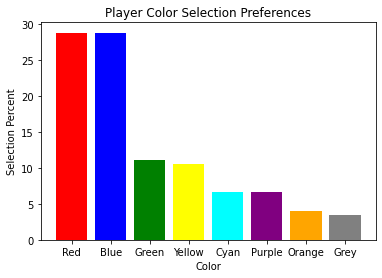

In [6]:
plt.bar(x=color_percent.color, height=color_percent.percent*100, color=color_percent.color)
plt.xlabel('Color')
plt.ylabel('Selection Percent')
plt.title('Player Color Selection Preferences')
plt.show()

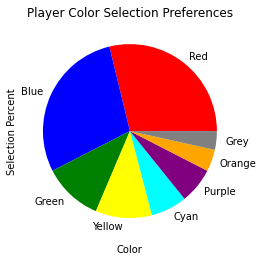

In [7]:
plt.pie(x=color_percent.percent, labels=color_percent.color, colors=color_percent.color)
plt.title('Player Color Selection Preferences')
plt.xlabel('Color')
plt.ylabel('Selection Percent')
plt.show()

In [24]:
most_recent_patch = max(matches.patch.unique()) # filter by this for now

In [13]:
# Okay colors are pretty, but we need to look at win rates to determine if this game is balanced as per our hypothesis
# matches.info()
# we see nulls for average_rating column. perhaps this is for players new to the game who have no rating (i.e., this is their first game).
# matches_copy = matches_copy.dropna(subset=['average_rating']) # don't need this if we just drop that column
# we have 1331699 non null for everything else, 1287122 for average_rating
# this will be our cleaned up matches. also we won't have to start from beginning and read csv if we mess up something
# we can also throw away useless columns
# print(matches.columns)
matches_copy = matches[['token', 'winning_team', 'ladder', 'patch', 'num_players', 'duration']].copy()
players_copy = players[['token', 'match', 'rating', 'civ', 'team', 'winner']].copy()



,player_token,match_token,rating,civ,team,winner
0,V2X8UjSoLUliuaqg,e2ef0bbea3378df2,1295.0,Goths,1,False
1,pafasA6Xv704IbMw,4a7b1a48021eb7b5,1549.0,Berbers,2,False
3,BZW0KSg7oZ4Nmoa6,d1f34eed030ca372,1183.0,Mayans,1,False
4,QAX39y010pa9q2Q6,346f298b1ced01fb,1326.0,Koreans,2,True
5,tujH7TExWtRbCFuD,b73a236bd12d6aa8,1229.0,Khmer,2,True


In [ ]:
# rename columns
matches_copy = matches_copy.rename(columns={'token': 'match_token'})
players_copy = players_copy.rename(columns={'token': 'player_token', 'match': 'match_token'})
players_copy = players_copy.dropna(subset=['rating'])

In [16]:
# join the datasets
mp_df = pd.merge(matches_copy, players_copy, on='match_token')

In [ ]:
# TODO need to use a datetime object to do this. look at it later
# we can also drop matches where someone ragequit (left quickly)
# matches_copy['duration'] = matches_copy['duration'].apply(lambda duration: int(duration.replace(':', '')))
# lowest values
# matches_copy[['duration']].sort_values(by='duration')
# highest values
# matches_copy[['duration']].sort_values(by='duration', ascending=False)

In [25]:
# we only want to look at 1v1s for now to determine balance
mp_df = mp_df[mp_df.ladder == 'RM_1v1']
# we only want to look at the latest patch for now. maybe later we can look at balance across patches or how patches affect balance?
mp_df = mp_df[mp_df.patch == most_recent_patch]


In [70]:
# look at win rates
win_rates = mp_df.groupby('civ')[['winner']].mean().reset_index().rename(columns={'winner': 'win_rate'}).sort_values(by='win_rate', ascending=False)


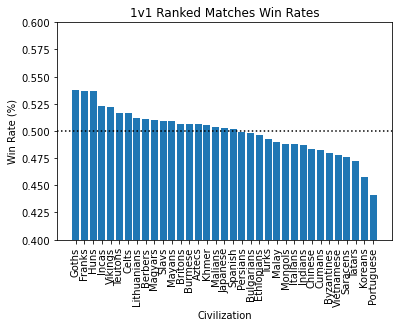

In [75]:
# plot win rates
plt.bar(win_rates.civ, win_rates.win_rate)
# TODO format y label as percent
plt.ylim(.4,.6)
plt.xticks(rotation=90)
plt.title('1v1 Ranked Matches Win Rates')
plt.xlabel('Civilization')
plt.ylabel('Win Rate (%)')

# draw a line at 50% to show how close to a coin flip this is
plt.axhline(0.5, color='black', linestyle=':')

plt.show()

In [72]:
# win rate stats
win_rates.agg(['mean', 'std'])

,win_rate
mean,0.499473
std,0.021016
